Imports for the project


In [1]:
import numpy as np
import networkx as netX
from sklearn.manifold import SpectralEmbedding
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import adjusted_rand_score
from sklearn.svm import SVC
import torch_geometric

In [36]:
edges_file_path = 'data/DD349/DD349.edges'
nodes_file_path = 'data/DD349/DD349.node_labels'

# Load edges
DD349_EDGES = np.genfromtxt(edges_file_path, dtype=int, delimiter=' ')

# Load node labels
DD349_LABELS = np.genfromtxt(nodes_file_path, dtype=int, delimiter=' ')
DD349_LABELS = DD349_LABELS[:, 1]

In [37]:
inData = DD349_EDGES # input data 
outData = DD349_LABELS # output data 

In [38]:
graph = netX.DiGraph()
graph.add_edges_from(inData)
print('Total {} nodes and {} edges in graph'.format(graph.number_of_nodes(), graph.number_of_edges()))

Total 897 nodes and 2087 edges in graph


In [39]:
EPOCHS = 1000
NUM_NODES = graph.number_of_nodes()
GIVEN_CLASSES = np.max(outData)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [43]:
train_mask = torch.zeros(NUM_NODES, dtype=torch.bool)
test_mask = torch.zeros(NUM_NODES, dtype=torch.bool)
train_mask[:int(NUM_NODES*0.8)] = True
test_mask[int(NUM_NODES*0.8):] = True

data = torch_geometric.data.Data(
    train_mask=train_mask,
    test_mask=test_mask,
    x=torch.eye(NUM_NODES), 
    edge_index=torch.tensor(inData-1, dtype=torch.long).t().contiguous(), 
    y=torch.nn.functional.one_hot(torch.tensor(outData-1, dtype=torch.long), GIVEN_CLASSES)).to(device)


In [44]:
adjacency_matrix = np.zeros((NUM_NODES, NUM_NODES))
adjacency_matrix[inData[:, 0]-1, inData[:, 1]-1] = 1
adjacency_matrix[inData[:, 1]-1, inData[:, 0]-1] = 1

## Model 1 : Graph Convolutional Network with 2 fully connected layers

In [45]:
class GraphConvolutionNetwork(torch.nn.Module):
    def __init__(self, num_node, num_classes):
        super(GraphConvolutionNetwork, self).__init__()
        self.conv1 = torch_geometric.nn.GCNConv(num_node, 128)
        self.fc1 = torch.nn.Linear(128, num_classes)


    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.nn.functional.relu(self.conv1(x, edge_index))
        return torch.nn.functional.softmax(self.fc1(x), dim=1)

In [46]:
model = GraphConvolutionNetwork(num_node=NUM_NODES, num_classes=GIVEN_CLASSES).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mse = torch.nn.MSELoss()

In [49]:
loss_list = []
acc_list = []

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = mse(out[data.train_mask], data.y[data.train_mask].float())
    loss.backward()
    optimizer.step()

    # validate the model
    model.eval()
    _, pred = model(data).max(dim=1)
    _, true_labels = torch.max(data.y.float(), dim=1)
    correct = float(pred[data.test_mask].eq(true_labels[data.test_mask]).sum().item())
    acc = correct / len(data.y)
    loss_list.append(loss.item())
    acc_list.append(acc)
    if epoch%10 == 0:
        print('Epoch: {} Loss: {} Test Accuracy: {}'.format(epoch, loss.item(), acc))

Epoch: 0 Loss: 0.002187458099797368 Test Accuracy: 0.19509476031215162
Epoch: 10 Loss: 0.0017949918983504176 Test Accuracy: 0.19843924191750278
Epoch: 20 Loss: 0.0013294746167957783 Test Accuracy: 0.19843924191750278
Epoch: 30 Loss: 0.0012383980210870504 Test Accuracy: 0.19843924191750278
Epoch: 40 Loss: 0.000759754388127476 Test Accuracy: 0.20066889632107024
Epoch: 50 Loss: 8.810152939986438e-05 Test Accuracy: 0.20066889632107024
Epoch: 60 Loss: 2.7612686608335935e-05 Test Accuracy: 0.20066889632107024
Epoch: 70 Loss: 1.7266536815441214e-05 Test Accuracy: 0.1995540691192865
Epoch: 80 Loss: 1.3082799341646023e-05 Test Accuracy: 0.1995540691192865
Epoch: 90 Loss: 1.1208783689653501e-05 Test Accuracy: 0.20066889632107024


In [50]:
# test the model
model.eval()
_, pred = model(data).max(dim=1)
_, true_labels = torch.max(data.y.float(), dim=1)
correct = float(pred.eq(true_labels).sum().item())
acc = correct / len(data.y)
print('Test Accuracy: {}'.format(acc))
print("Adjusted Rand Index: {}".format(adjusted_rand_score(pred.cpu().numpy(), true_labels.cpu().numpy())))

Test Accuracy: 1.0
Adjusted Rand Index: 1.0


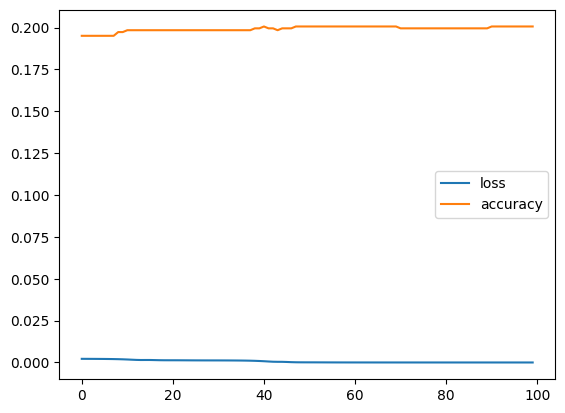

In [51]:
# plot loss and accuracy
plt.plot(loss_list)
plt.plot(acc_list)
plt.legend(['loss', 'accuracy'])
plt.show()

## Model 2 : Graph Encoder Embedding

In [54]:
class GraphEncoderEmbedding(torch.nn.Module):
    def __init__(self, num_nodes, num_classes):
        super(GraphEncoderEmbedding, self).__init__()
        self.conv1 = torch_geometric.nn.GCNConv(num_nodes, 256)
        self.conv2 = torch_geometric.nn.GCNConv(256, num_classes)

    def forward(self, x, edge_index):
        
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = torch.nn.functional.log_softmax(x, dim=1)
        return x

In [55]:
model = GraphEncoderEmbedding(num_nodes=NUM_NODES, num_classes=GIVEN_CLASSES).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

In [56]:
loss_list_gee = []
accuracy_list_gee = []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask].float())
    loss.backward()
    optimizer.step()

    # validate the model
    model.eval()
    _, pred = model(data.x, data.edge_index).max(dim=1)
    _, true_labels = torch.max(data.y.float(), dim=1)
    correct = float(pred[data.test_mask].eq(true_labels[data.test_mask]).sum().item())
    acc = correct / len(data.y[data.test_mask])
    loss_list_gee.append(loss.item())
    accuracy_list_gee.append(acc)
    if epoch%100 == 0:
        print('Epoch: {} Loss: {} Test Accuracy: {}'.format(epoch, loss.item(), acc))

Epoch: 0 Loss: 2.9985859394073486 Test Accuracy: 0.03888888888888889
Epoch: 100 Loss: 0.6194441914558411 Test Accuracy: 0.03888888888888889
Epoch: 200 Loss: 0.5457534193992615 Test Accuracy: 0.03333333333333333
Epoch: 300 Loss: 0.5380569696426392 Test Accuracy: 0.05
Epoch: 400 Loss: 0.5231691598892212 Test Accuracy: 0.03888888888888889
Epoch: 500 Loss: 0.5158518552780151 Test Accuracy: 0.05
Epoch: 600 Loss: 0.5084226131439209 Test Accuracy: 0.044444444444444446
Epoch: 700 Loss: 0.5122314691543579 Test Accuracy: 0.03888888888888889
Epoch: 800 Loss: 0.5178695917129517 Test Accuracy: 0.05555555555555555
Epoch: 900 Loss: 0.4987855851650238 Test Accuracy: 0.044444444444444446


In [53]:
# test the model
model.eval()
_, pred = model(data.x, data.edge_index).max(dim=1)
_, true_labels = torch.max(data.y.float(), dim=1)
correct = float(pred.eq(true_labels).sum().item())
acc = correct / len(data.y)
print('Test Accuracy: {}'.format(acc))

TypeError: GraphConvolutionNetwork.forward() takes 2 positional arguments but 3 were given

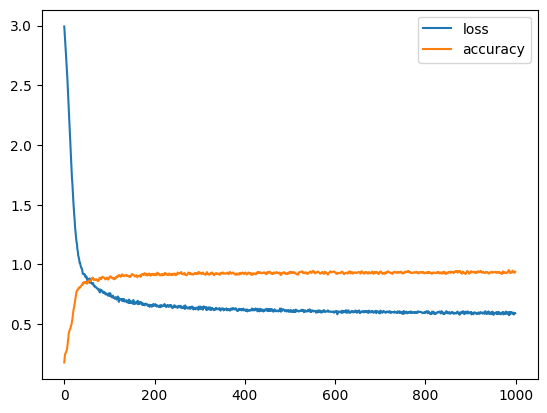

In [17]:
# plot loss and accuracy
plt.plot(loss_list)
plt.plot(accuracy_list)
plt.legend(['loss', 'accuracy'])
plt.show()

In [18]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)

out = out.cpu().numpy().argmax(axis=1)

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(out.reshape(-1, 1), outData, test_size=0.2, random_state=42)

lda = LinearDiscriminantAnalysis()
lda.fit(X_TRAIN, Y_TRAIN)
y_pred = lda.predict(X_TRAIN)

print("Training Accuracy LDA:")
print(f"Accuracy: {np.sum(Y_TRAIN == y_pred) / len(Y_TRAIN)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TRAIN, y_pred)}")

print("Testing Accuracy LDA:")
print(f"Accuracy: {np.sum(Y_TEST == lda.predict(X_TEST)) / len(Y_TEST)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y_TEST, lda.predict(X_TEST))}")

Training Accuracy LDA:
Accuracy: 0.5397489539748954
Adjusted Rand Index: 0.5179413232701318
Testing Accuracy LDA:
Accuracy: 0.5111111111111111
Adjusted Rand Index: 0.5570838931610878


## Model 3 : Spectral Embedding

In [19]:
embedding = SpectralEmbedding(n_components=NUM_NODES-10)
spectral_embedding = embedding.fit_transform(adjacency_matrix, outData)

In [20]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(spectral_embedding, outData, test_size=0.2, random_state=42)

In [26]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_TRAIN, Y_TRAIN)
y_pred = lda.predict(X_TRAIN)

print("Training Accuracy LDA:")
print("Accuracy: {}".format(np.sum(Y_TRAIN == y_pred) / len(Y_TRAIN)))
print("Adjusted Rand Index: {}".format(adjusted_rand_score(Y_TRAIN, y_pred)))

print("\nTesting Accuracy LDA:")
print("Accuracy: {}".format(np.sum(Y_TEST == lda.predict(X_TEST)) / len(Y_TEST)))
print("Adjusted Rand Index: {}".format(adjusted_rand_score(Y_TEST, lda.predict(X_TEST))))

Training Accuracy LDA:
Accuracy: 0.898186889818689
Adjusted Rand Index: 0.7987605630443704

Testing Accuracy LDA:
Accuracy: 0.07222222222222222
Adjusted Rand Index: -0.00893247849179617


In [25]:
svc = SVC()
svc.fit(X_TRAIN, Y_TRAIN)
y_pred = svc.predict(X_TRAIN)

print("Training Accuracy SVC:")
print("Accuracy: {}".format(np.sum(Y_TRAIN == y_pred) / len(Y_TRAIN)))
print("Adjusted Rand Index: {}".format(adjusted_rand_score(Y_TRAIN, y_pred)))

print("\nTesting Accuracy SVC:")
print("Accuracy: {}".format(np.sum(Y_TEST == svc.predict(X_TEST)) / len(Y_TEST)))
print("Adjusted Rand Index: {}".format(adjusted_rand_score(Y_TEST, svc.predict(X_TEST))))

Training Accuracy SVC:
Accuracy: 0.9149232914923291
Adjusted Rand Index: 0.7714927096248679

Testing Accuracy SVC:
Accuracy: 0.06666666666666667
Adjusted Rand Index: -0.0006716271967302455
